## Transfer Learning

Remeber how in lesson 2 we saw that Convolutional Neural Networks learn simple features in the first layer, and more complicated features in the later layers?

<img src="../data/lesson_images/layer1.png" alt="Activations of the first layer of a CNN" width="300" caption="Activations of the first layer of a CNN (courtesy of Matthew D. Zeiler and Rob Fergus)" id="img_layer1">


<img src="../data/lesson_images/layer2.png" alt="Activations of the second layer of a CNN" width="800" caption="Activations of the second layer of a CNN (courtesy of Matthew D. Zeiler and Rob Fergus)" id="img_layer2">

<img src="../data/lesson_images/chapter2_layer3.PNG" alt="Activations of the third layer of a CNN" width="800" caption="Activations of the third layer of a CNN (courtesy of Matthew D. Zeiler and Rob Fergus)" id="img_layer3">

<img src="../data/lesson_images/chapter2_layer4and5.PNG" alt="Activations of layers 4 and 5 of a CNN" width="800" caption="Activations of layers 4 and 5 of a CNN (courtesy of Matthew D. Zeiler and Rob Fergus)" id="img_layer4">

The idea of **transfer learning** is that we take the first and middle layers from a CNN that has *already been trained*. This is because they are able to recognise generally useful features such as circles and faces. 

We then add fresh last layers - the **head** - and train them to recognise the particular objects we want to recognise.

In [2]:
# DO NOT CHANGE THIS CODE

import fastbook
fastbook.setup_book()

from icrawler.builtin import BingImageCrawler
from pathlib import Path

In [3]:
# DO NOT CHANGE THIS CODE

from fastbook import *
from fastai.vision.widgets import *

In [ ]:
# Feel free to change these categories to something you want to teach your model
# ..eg dogs vs cats
# ..or cats vs bats 

# The word on the left is the name of the category
# The sentence on the right is a search term that will find images of that category on the internet

categories = {
    'oyster':             'oyster mushroom pleurotus ostreatus',
    'death_cap':          'death cap mushroom amanita phalloides',
}

In [ ]:
# DO NOT CHANGE THIS CODE

# Here we download images of the above categories from the internet to use as training data

training_images_folder = 'training_images'

for cls, term in categories.items():
    dest = Path(training_images_folder)/cls
    dest.mkdir(parents=True, exist_ok=True)
    crawler = BingImageCrawler(storage={'root_dir': str(dest)})
    crawler.crawl(keyword=term, max_num=10, min_size=(200,200), overwrite=True)


2025-07-12 03:05:36,290 - INFO - icrawler.crawler - start crawling...
2025-07-12 03:05:36,291 - INFO - icrawler.crawler - starting 1 feeder threads...
2025-07-12 03:05:36,294 - INFO - feeder - thread feeder-001 exit
2025-07-12 03:05:36,295 - INFO - icrawler.crawler - starting 1 parser threads...
2025-07-12 03:05:36,299 - INFO - icrawler.crawler - starting 1 downloader threads...
2025-07-12 03:05:41,302 - INFO - downloader - downloader-001 is waiting for new download tasks
2025-07-12 03:05:46,305 - INFO - downloader - downloader-001 is waiting for new download tasks
2025-07-12 03:05:51,308 - INFO - downloader - downloader-001 is waiting for new download tasks
2025-07-12 03:05:56,310 - INFO - downloader - downloader-001 is waiting for new download tasks
2025-07-12 03:05:56,328 - ERROR - parser - Exception caught when fetching page https://www.bing.com/images/async?q=common button mushroom agaricus bisporus&first=0, error: HTTPSConnectionPool(host='www.bing.com', port=443): Max retries ex

2025-07-12 03:06:26,560 - INFO - parser - downloaded image reached max num, thread parser-001 is ready to exit
2025-07-12 03:06:26,562 - INFO - parser - thread parser-001 exit


In [6]:
# DO NOT CHANGE THIS CODE

# Here we remove any images that failed to download correctly

failed = verify_images(get_image_files(training_images_folder))
failed.map(Path.unlink)  # delete any that failed to open

(#0) []

In [7]:
# DO NOT CHANGE THIS CODE

training_image_filenames = get_image_files(training_images_folder)

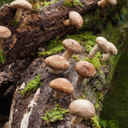

In [8]:
# DO NOT CHANGE THIS CODE

# Let's look at one of the images we downloaded

im = Image.open(training_image_filenames[0])
im.to_thumb(128,128)

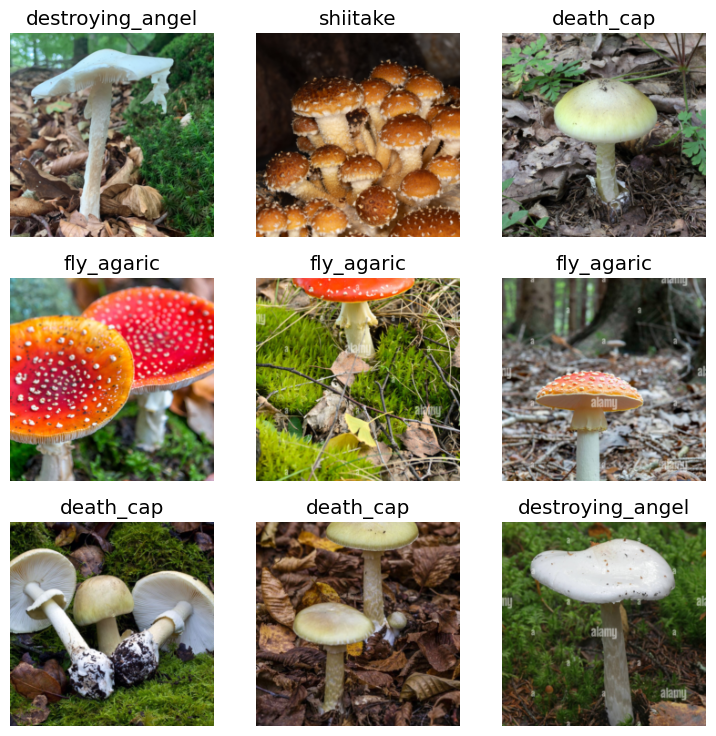

In [9]:
# DO NOT CHANGE THIS CODE

# These are NOT AI preditions
# Instead, these are some of the images we downloaded, along with their category names
# You should check that the images are correct for the category names as this is our training data

path = Path(training_images_folder)
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224)
)

dls = dblock.dataloaders(path, bs=16)
dls.show_batch(max_n=9)


In [10]:
# DO NOT CHANGE THIS CODE

# Here we copy an existing trained model (resnet34) and train the head of the model to recognize our categories

learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,3.129859,3.604538,0.900000,00:03


epoch,train_loss,valid_loss,error_rate,time
0,2.349929,2.680888,0.900000,00:02
1,1.572308,1.875611,0.700000,00:02
2,1.195096,1.504586,0.500000,00:02


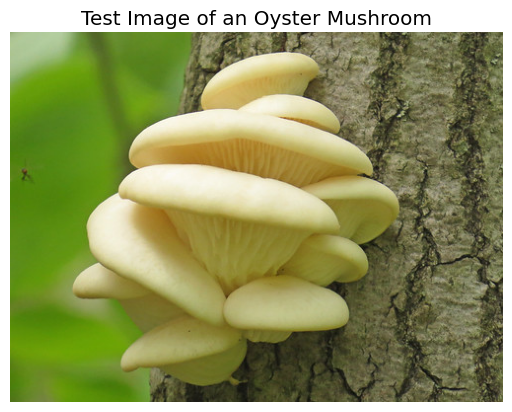

In [11]:
# Feel free to change this code

# Change the URL to an image on the internet you want to test 
# The image should be of one of the categories you trained your model on

# 1) Make a test folder
test_path = Path('test_images')
test_path.mkdir(exist_ok=True)

# 2) Download your image
url = 'https://live.staticflickr.com/2927/14293282232_03499896bb.jpg'  # ← replace with your URL
save_filename = 'testOysterMushroom'                       # derive a filename
save_path = test_path/save_filename

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64)',
    'Referer': 'https://www.flickr.com/'
}

resp = requests.get(url, headers=headers)
resp.raise_for_status()  # will crash if download failed
with open(save_path,'wb') as f:
    f.write(resp.content)


image_path = test_path/save_filename  

plt.imshow(PILImage.create(image_path))
plt.axis('off')
plt.title('Test Image of an Oyster Mushroom')
plt.show()


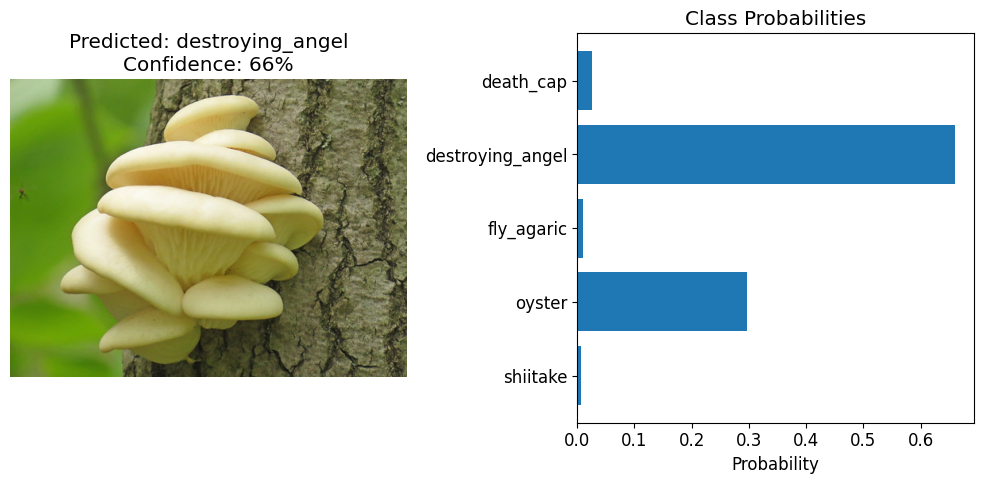

In [12]:
# Feel free to change this code

# Here we predict the category of the image we downloaded

# If you want to upload your own image, save it in the test_images folder as "my_image.jpg" 
# .. and uncomment the line below: image_path = test_path/'my_image.jpg'

# image_path = test_path/'my_image.jpg'  


image = PILImage.create(image_path) # open the image we downloaded
pred_class, pred_idx, probs = learn.predict(image)


fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Left: show the image with its predicted label
axes[0].imshow(image)
axes[0].axis('off')
axes[0].set_title(f'Predicted: {pred_class}\nConfidence: {probs[pred_idx]:.0%}')

# Right: bar-chart of all class probabilities
classes = learn.dls.vocab
axes[1].barh(classes, probs)
axes[1].invert_yaxis()                # highest probability at top
axes[1].set_xlabel('Probability')
axes[1].set_title('Class Probabilities')

plt.tight_layout()
plt.show()

